In [1]:
%matplotlib inline
from copy import deepcopy
from collections import OrderedDict
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD,Adam,lr_scheduler
from torch.utils.data import random_split
import torchvision
from torchvision import transforms,models
import copy
from timeit import default_timer as timer
import tqdm

In [2]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=.40),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# If downloaded: download=False
traindata = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainset,valset = random_split(traindata,[42000,8000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64,shuffle=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=False)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(pretrained=True)
        self.base = nn.Sequential(*list(base.children())[:-1])
        in_features = base.fc.in_features
        self.drop = nn.Dropout()
        self.final = nn.Linear(in_features,10)
    
    def forward(self,x):
        x = self.base(x)
        x = self.drop(x.view(-1,self.final.in_features))
        return self.final(x)
    
model = Model().cuda()
[x for x,y in model.named_children()]

D:\Anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['base', 'drop', 'final']

In [4]:
criterion = nn.CrossEntropyLoss()
param_groups = [
    {'params':model.base.parameters(),'lr':.0001},
    {'params':model.final.parameters(),'lr':.001}
]
optimizer = Adam(param_groups)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
states = {}

In [ ]:
%%time
best_val_acc = -1000
best_val_model = None
for epoch in range(10):  
    model.train(True)
    running_loss = 0.0
    running_acc = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.cuda(),labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() * inputs.size(0)
        out = torch.argmax(outputs.detach(),dim=1)
        assert out.shape==labels.shape
        running_acc += (labels==out).sum().item()
    print(f"Train loss {epoch+1}: {running_loss/len(trainset)},Train Acc:{running_acc*100/len(trainset)}%")
    
    correct = 0
    model.train(False)
    with torch.no_grad():
        for inputs,labels in valloader:
            out = model(inputs.cuda()).cpu()
            out = torch.argmax(out,dim=1)
            acc = (out==labels).sum().item()
            correct += acc
    print(f"Val accuracy:{correct*100/len(valset)}%")
    if correct>best_val_acc:
        best_val_acc = correct
        best_val_model = deepcopy(model.state_dict())
    lr_scheduler.step()
    
print('Finished Training') 

In [16]:
torch.save(model.state_dict(), r'.\resnet18_bef.pth')

In [5]:
state_dict = torch.load(r'.\resnet18_bef.pth')
print(state_dict.keys())

odict_keys(['base.0.weight', 'base.1.weight', 'base.1.bias', 'base.1.running_mean', 'base.1.running_var', 'base.1.num_batches_tracked', 'base.4.0.conv1.weight', 'base.4.0.bn1.weight', 'base.4.0.bn1.bias', 'base.4.0.bn1.running_mean', 'base.4.0.bn1.running_var', 'base.4.0.bn1.num_batches_tracked', 'base.4.0.conv2.weight', 'base.4.0.bn2.weight', 'base.4.0.bn2.bias', 'base.4.0.bn2.running_mean', 'base.4.0.bn2.running_var', 'base.4.0.bn2.num_batches_tracked', 'base.4.1.conv1.weight', 'base.4.1.bn1.weight', 'base.4.1.bn1.bias', 'base.4.1.bn1.running_mean', 'base.4.1.bn1.running_var', 'base.4.1.bn1.num_batches_tracked', 'base.4.1.conv2.weight', 'base.4.1.bn2.weight', 'base.4.1.bn2.bias', 'base.4.1.bn2.running_mean', 'base.4.1.bn2.running_var', 'base.4.1.bn2.num_batches_tracked', 'base.5.0.conv1.weight', 'base.5.0.bn1.weight', 'base.5.0.bn1.bias', 'base.5.0.bn1.running_mean', 'base.5.0.bn1.running_var', 'base.5.0.bn1.num_batches_tracked', 'base.5.0.conv2.weight', 'base.5.0.bn2.weight', 'base.

In [6]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [7]:
#check accuracy for original model
correct = 0
model.train(False)
with torch.no_grad():
    for inputs,labels in valloader:
        out = model(inputs.cuda()).cpu()
        out = torch.argmax(out,dim=1)
        acc = (out==labels).sum().item()
        correct += acc
print(f"Val accuracy:{correct*100/len(valset)}%")

Val accuracy:94.575%


In [8]:
def get_cpu_inference_time_and_test_acc(model, test_loader):
    test_data_size = len(testloader.dataset)
    cpu_device = torch.device("cpu")
    model = model.to(cpu_device)
    # Wam-up
    # Because I sequentially run each cell above, and they includes for loop, I assume the CPU is warmed up
#     torch.cuda.synchronize()
    elapsed_time_ms = 0
    start = timer()
    # Start Inference Phase
    correct = 0
    with torch.no_grad():
        for imgs, labels in tqdm.tqdm(test_loader):
#             imgs, labels = imgs.cuda(), labels.cuda()
            imgs, labels = imgs.to(cpu_device), labels.to(cpu_device)
            out = model(imgs.float())
            predictions = out.argmax(dim=1, keepdim=True)  
            correct += predictions.eq(labels.view_as(predictions)).sum().item()
#             break
    accuracy = correct/len(test_loader.dataset)
    print(accuracy)
    # End of inference Phase
#     torch.cuda.synchronize()
    end = timer()
    elapsed_time_ms = (end - start) * 1000
    per_sample = elapsed_time_ms/test_data_size
    print("CPU Inference time is " + str(per_sample)+ ' ms')
    return per_sample, accuracy

In [9]:
# Original Model
torch.cuda.empty_cache()
criterion=torch.nn.CrossEntropyLoss()
model.eval()
cpu_inf_time, acc = get_cpu_inference_time_and_test_acc(model, testloader)

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [01:43<00:00,  1.52it/s]

0.9412
CPU Inference time is 10.356740440000001 ms


In [9]:
import torch.nn.utils.prune as prune

In [10]:
parameters_to_prune1 =[] # 0.1
parameters_to_prune2 =[] # 0.3
parameters_to_prune3 =[] # 0.5
parameters_to_prune4 =[] # 0.7
parameters_to_prune5 =[] # 0.9

compressed_model1 = copy.deepcopy(model)
compressed_model2 = copy.deepcopy(model)
compressed_model3 = copy.deepcopy(model)
compressed_model4 = copy.deepcopy(model)
compressed_model5 = copy.deepcopy(model)

In [11]:
parameters_to_prune1.append((compressed_model1.base[0],'weight'))
parameters_to_prune1.append((compressed_model1.base[1],'weight'))
parameters_to_prune1.append((compressed_model1.base[1],'bias'))

parameters_to_prune2.append((compressed_model2.base[0],'weight'))
parameters_to_prune2.append((compressed_model2.base[1],'weight'))
parameters_to_prune2.append((compressed_model2.base[1],'bias'))

parameters_to_prune3.append((compressed_model3.base[0],'weight'))
parameters_to_prune3.append((compressed_model3.base[1],'weight'))
parameters_to_prune3.append((compressed_model3.base[1],'bias'))

parameters_to_prune4.append((compressed_model4.base[0],'weight'))
parameters_to_prune4.append((compressed_model4.base[1],'weight'))
parameters_to_prune4.append((compressed_model4.base[1],'bias'))

parameters_to_prune5.append((compressed_model5.base[0],'weight'))
parameters_to_prune5.append((compressed_model5.base[1],'weight'))
parameters_to_prune5.append((compressed_model5.base[1],'bias'))

In [12]:
for i in range(4,8):
    for j in range(0,2):
        parameters_to_prune1.append((compressed_model1.base[i][j].conv1,"weight"))
        parameters_to_prune1.append((compressed_model1.base[i][j].bn1,"weight"))
        parameters_to_prune1.append((compressed_model1.base[i][j].bn1,"bias"))
        parameters_to_prune1.append((compressed_model1.base[i][j].conv2,"weight"))
        parameters_to_prune1.append((compressed_model1.base[i][j].bn2,"weight"))
        parameters_to_prune1.append((compressed_model1.base[i][j].bn2,"bias"))
    
for i in range(4,8):
    for j in range(0,2):
        parameters_to_prune2.append((compressed_model2.base[i][j].conv1,"weight"))
        parameters_to_prune2.append((compressed_model2.base[i][j].bn1,"weight"))
        parameters_to_prune2.append((compressed_model2.base[i][j].bn1,"bias"))
        parameters_to_prune2.append((compressed_model2.base[i][j].conv2,"weight"))
        parameters_to_prune2.append((compressed_model2.base[i][j].bn2,"weight"))
        parameters_to_prune2.append((compressed_model2.base[i][j].bn2,"bias"))
        
for i in range(4,8):
    for j in range(0,2):
        parameters_to_prune3.append((compressed_model3.base[i][j].conv1,"weight"))
        parameters_to_prune3.append((compressed_model3.base[i][j].bn1,"weight"))
        parameters_to_prune3.append((compressed_model3.base[i][j].bn1,"bias"))
        parameters_to_prune3.append((compressed_model3.base[i][j].conv2,"weight"))
        parameters_to_prune3.append((compressed_model3.base[i][j].bn2,"weight"))
        parameters_to_prune3.append((compressed_model3.base[i][j].bn2,"bias"))

for i in range(4,8):
    for j in range(0,2):
        parameters_to_prune4.append((compressed_model4.base[i][j].conv1,"weight"))
        parameters_to_prune4.append((compressed_model4.base[i][j].bn1,"weight"))
        parameters_to_prune4.append((compressed_model4.base[i][j].bn1,"bias"))
        parameters_to_prune4.append((compressed_model4.base[i][j].conv2,"weight"))
        parameters_to_prune4.append((compressed_model4.base[i][j].bn2,"weight"))
        parameters_to_prune4.append((compressed_model4.base[i][j].bn2,"bias"))
        
for i in range(4,8):
    for j in range(0,2):
        parameters_to_prune5.append((compressed_model5.base[i][j].conv1,"weight"))
        parameters_to_prune5.append((compressed_model5.base[i][j].bn1,"weight"))
        parameters_to_prune5.append((compressed_model5.base[i][j].bn1,"bias"))
        parameters_to_prune5.append((compressed_model5.base[i][j].conv2,"weight"))
        parameters_to_prune5.append((compressed_model5.base[i][j].bn2,"weight"))
        parameters_to_prune5.append((compressed_model5.base[i][j].bn2,"bias"))

In [13]:
for i in range(5,8):
    parameters_to_prune1.append((compressed_model1.base[i][0].downsample[0],"weight"))
    parameters_to_prune1.append((compressed_model1.base[i][0].downsample[1],"weight"))
    parameters_to_prune1.append((compressed_model1.base[i][0].downsample[1],"bias"))
    
for i in range(5,8):
    parameters_to_prune2.append((compressed_model2.base[i][0].downsample[0],"weight"))
    parameters_to_prune2.append((compressed_model2.base[i][0].downsample[1],"weight"))
    parameters_to_prune2.append((compressed_model2.base[i][0].downsample[1],"bias"))
    
for i in range(5,8):
    parameters_to_prune3.append((compressed_model3.base[i][0].downsample[0],"weight"))
    parameters_to_prune3.append((compressed_model3.base[i][0].downsample[1],"weight"))
    parameters_to_prune3.append((compressed_model3.base[i][0].downsample[1],"bias"))
    
for i in range(5,8):
    parameters_to_prune4.append((compressed_model4.base[i][0].downsample[0],"weight"))
    parameters_to_prune4.append((compressed_model4.base[i][0].downsample[1],"weight"))
    parameters_to_prune4.append((compressed_model4.base[i][0].downsample[1],"bias"))
    
for i in range(5,8):
    parameters_to_prune5.append((compressed_model5.base[i][0].downsample[0],"weight"))
    parameters_to_prune5.append((compressed_model5.base[i][0].downsample[1],"weight"))
    parameters_to_prune5.append((compressed_model5.base[i][0].downsample[1],"bias"))

In [14]:
parameters_to_prune1 = tuple(parameters_to_prune1)
parameters_to_prune2 = tuple(parameters_to_prune2)
parameters_to_prune3 = tuple(parameters_to_prune3)
parameters_to_prune4 = tuple(parameters_to_prune4)
parameters_to_prune5 = tuple(parameters_to_prune5)

In [15]:
prune.global_unstructured(
        parameters_to_prune1,
        pruning_method=prune.L1Unstructured,
        amount=0.1,
    )
prune.global_unstructured(
        parameters_to_prune2,
        pruning_method=prune.L1Unstructured,
        amount=0.3,
    )
prune.global_unstructured(
        parameters_to_prune3,
        pruning_method=prune.L1Unstructured,
        amount=0.5,
    )
prune.global_unstructured(
        parameters_to_prune4,
        pruning_method=prune.L1Unstructured,
        amount=0.7,
    )
prune.global_unstructured(
        parameters_to_prune5,
        pruning_method=prune.L1Unstructured,
        amount=0.9,
    )

In [16]:
prune.remove(compressed_model1.base[0],'weight')
prune.remove(compressed_model1.base[1],'weight')
prune.remove(compressed_model1.base[1],'bias')

prune.remove(compressed_model2.base[0],'weight')
prune.remove(compressed_model2.base[1],'weight')
prune.remove(compressed_model2.base[1],'bias')

prune.remove(compressed_model3.base[0],'weight')
prune.remove(compressed_model3.base[1],'weight')
prune.remove(compressed_model3.base[1],'bias')

prune.remove(compressed_model4.base[0],'weight')
prune.remove(compressed_model4.base[1],'weight')
prune.remove(compressed_model4.base[1],'bias')

prune.remove(compressed_model5.base[0],'weight')
prune.remove(compressed_model5.base[1],'weight')
prune.remove(compressed_model5.base[1],'bias')

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [17]:
for i in range(4,8):
    for j in range(0,2):
        prune.remove(compressed_model1.base[i][j].conv1,"weight")
        prune.remove(compressed_model1.base[i][j].bn1,"weight")
        prune.remove(compressed_model1.base[i][j].bn1,"bias")
        prune.remove(compressed_model1.base[i][j].conv2,"weight")
        prune.remove(compressed_model1.base[i][j].bn2,"weight")
        prune.remove(compressed_model1.base[i][j].bn2,"bias")
        
        prune.remove(compressed_model2.base[i][j].conv1,"weight")
        prune.remove(compressed_model2.base[i][j].bn1,"weight")
        prune.remove(compressed_model2.base[i][j].bn1,"bias")
        prune.remove(compressed_model2.base[i][j].conv2,"weight")
        prune.remove(compressed_model2.base[i][j].bn2,"weight")
        prune.remove(compressed_model2.base[i][j].bn2,"bias")
        
        prune.remove(compressed_model3.base[i][j].conv1,"weight")
        prune.remove(compressed_model3.base[i][j].bn1,"weight")
        prune.remove(compressed_model3.base[i][j].bn1,"bias")
        prune.remove(compressed_model3.base[i][j].conv2,"weight")
        prune.remove(compressed_model3.base[i][j].bn2,"weight")
        prune.remove(compressed_model3.base[i][j].bn2,"bias")
        
        prune.remove(compressed_model4.base[i][j].conv1,"weight")
        prune.remove(compressed_model4.base[i][j].bn1,"weight")
        prune.remove(compressed_model4.base[i][j].bn1,"bias")
        prune.remove(compressed_model4.base[i][j].conv2,"weight")
        prune.remove(compressed_model4.base[i][j].bn2,"weight")
        prune.remove(compressed_model4.base[i][j].bn2,"bias")
        
        prune.remove(compressed_model5.base[i][j].conv1,"weight")
        prune.remove(compressed_model5.base[i][j].bn1,"weight")
        prune.remove(compressed_model5.base[i][j].bn1,"bias")
        prune.remove(compressed_model5.base[i][j].conv2,"weight")
        prune.remove(compressed_model5.base[i][j].bn2,"weight")
        prune.remove(compressed_model5.base[i][j].bn2,"bias")

In [18]:
for i in range(5,8):
    prune.remove(compressed_model1.base[i][0].downsample[0],"weight")
    prune.remove(compressed_model1.base[i][0].downsample[1],"weight")
    prune.remove(compressed_model1.base[i][0].downsample[1],"bias")
    
    prune.remove(compressed_model2.base[i][0].downsample[0],"weight")
    prune.remove(compressed_model2.base[i][0].downsample[1],"weight")
    prune.remove(compressed_model2.base[i][0].downsample[1],"bias")
    
    prune.remove(compressed_model3.base[i][0].downsample[0],"weight")
    prune.remove(compressed_model3.base[i][0].downsample[1],"weight")
    prune.remove(compressed_model3.base[i][0].downsample[1],"bias")
    
    prune.remove(compressed_model4.base[i][0].downsample[0],"weight")
    prune.remove(compressed_model4.base[i][0].downsample[1],"weight")
    prune.remove(compressed_model4.base[i][0].downsample[1],"bias")
    
    prune.remove(compressed_model5.base[i][0].downsample[0],"weight")
    prune.remove(compressed_model5.base[i][0].downsample[1],"weight")
    prune.remove(compressed_model5.base[i][0].downsample[1],"bias")

In [19]:
torch.save(compressed_model1.state_dict(), r'.\resnet18_compressed1_pruning.pth')
torch.save(compressed_model2.state_dict(), r'.\resnet18_compressed2_pruning.pth')
torch.save(compressed_model3.state_dict(), r'.\resnet18_compressed3_pruning.pth')
torch.save(compressed_model4.state_dict(), r'.\resnet18_compressed4_pruning.pth')
torch.save(compressed_model5.state_dict(), r'.\resnet18_compressed5_pruning.pth')

In [18]:
torch.cuda.empty_cache()
criterion=torch.nn.CrossEntropyLoss()
compressed_model1.eval()
cpu_inf_time1, acc1 = get_cpu_inference_time_and_test_acc(compressed_model1, testloader)

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [01:49<00:00,  1.44it/s]

0.9419
CPU Inference time is 10.929069049999999 ms


In [19]:
torch.cuda.empty_cache()
criterion=torch.nn.CrossEntropyLoss()
compressed_model2.eval()
cpu_inf_time2, acc2 = get_cpu_inference_time_and_test_acc(compressed_model2, testloader)

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [01:47<00:00,  1.47it/s]

0.9403
CPU Inference time is 10.708836489999998 ms


In [20]:
torch.cuda.empty_cache()
criterion=torch.nn.CrossEntropyLoss()
compressed_model3.eval()
cpu_inf_time3, acc3 = get_cpu_inference_time_and_test_acc(compressed_model3, testloader)

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [01:46<00:00,  1.47it/s]

0.93
CPU Inference time is 10.677233850000004 ms


In [21]:
torch.cuda.empty_cache()
criterion=torch.nn.CrossEntropyLoss()
compressed_model4.eval()
cpu_inf_time4, acc4 = get_cpu_inference_time_and_test_acc(compressed_model4, testloader)

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [01:46<00:00,  1.47it/s]

0.8265
CPU Inference time is 10.650530850000008 ms


In [22]:
torch.cuda.empty_cache()
criterion=torch.nn.CrossEntropyLoss()
compressed_model5.eval()
cpu_inf_time5, acc5 = get_cpu_inference_time_and_test_acc(compressed_model5, testloader)

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [01:46<00:00,  1.48it/s]

0.0996
CPU Inference time is 10.60190606000001 ms


In [32]:
cpu_data = {'l1_unstructed': [cpu_inf_time,
                              cpu_inf_time1, 
                              cpu_inf_time2,
                              cpu_inf_time3,
                              cpu_inf_time4,
                              cpu_inf_time5],
           'Proportion': ['0.0','0.1','0.3','0.5','0.7','0.9']}
cpu_df = pd.DataFrame.from_dict(cpu_data, orient='columns').set_index('Proportion')
display(cpu_df)
cpu_df.to_csv("ResNet18_cpu_inf.csv")

,l1_unstructed
Proportion,
0.0,10.356740
0.1,10.929069
0.3,10.708836
0.5,10.677234
0.7,10.650531
0.9,10.601906


In [33]:
acc_data = {'l1_unstructed': [acc,
                              acc1, 
                              acc2,
                              acc3,
                              acc4,
                              acc5],
           'Proportion': ['0.0','0.1','0.3','0.5','0.7','0.9']}
acc_df = pd.DataFrame.from_dict(acc_data, orient='columns').set_index('Proportion')
display(acc_df)
acc_df.to_csv("ResNet18_acc.csv")

,l1_unstructed
Proportion,
0.0,0.9412
0.1,0.9419
0.3,0.9403
0.5,0.9300
0.7,0.8265
0.9,0.0996


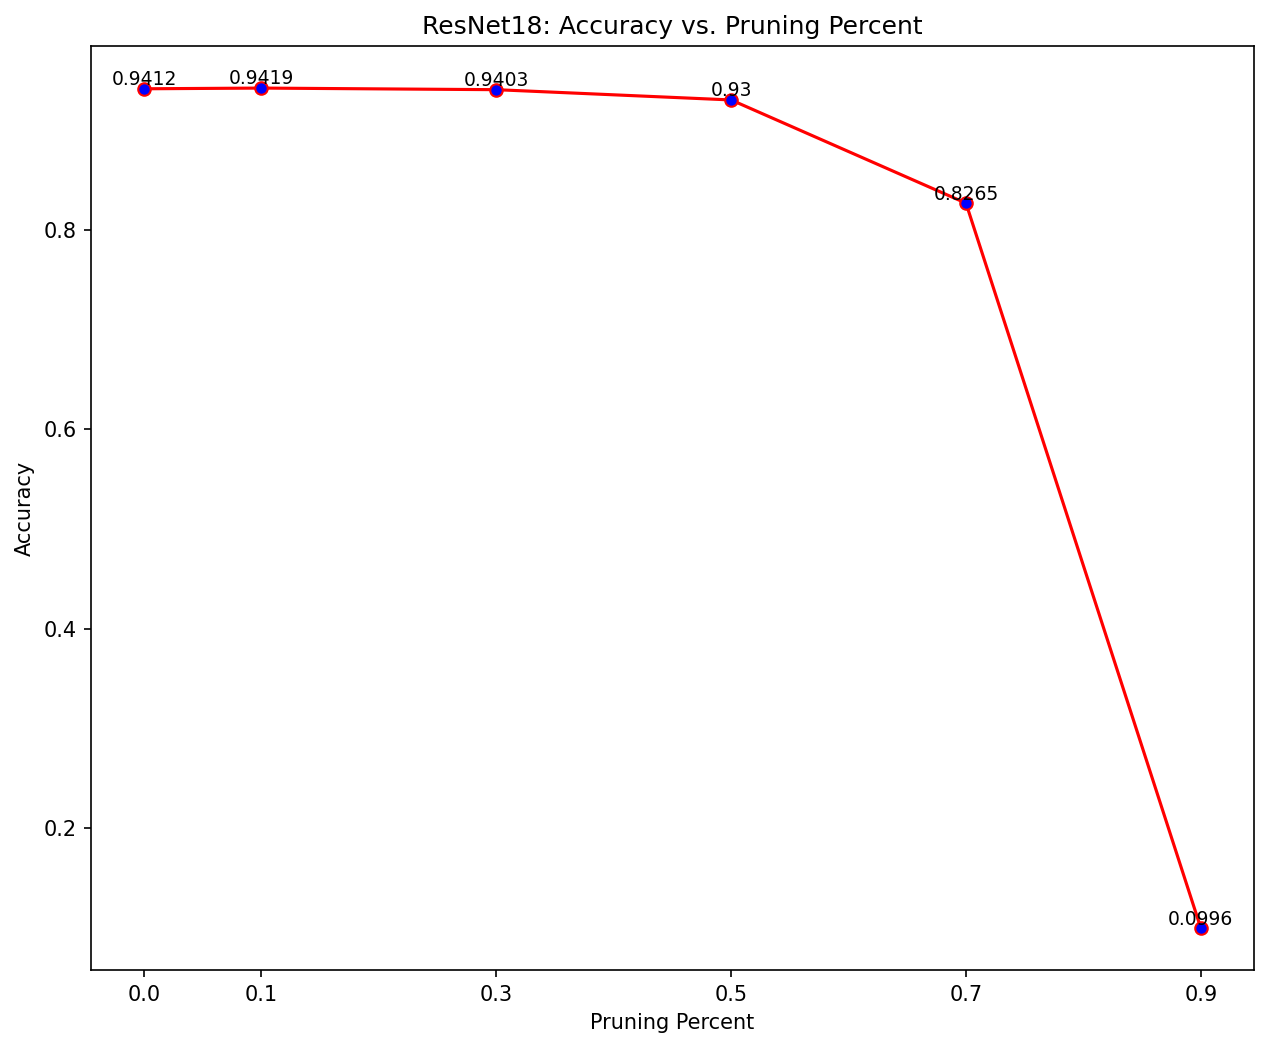

In [31]:
accuracy = [acc, acc1, acc2, acc3, acc4, acc5]
percent = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]

plt.figure(figsize=(10,8),dpi=150)
plt.plot(percent, accuracy, color='r', marker='o', markerfacecolor='blue')
plt.xticks ([0.0, 0.1, 0.3, 0.5, 0.7, 0.9])
plt.title("ResNet18: Accuracy vs. Pruning Percent")
plt.xlabel("Pruning Percent")
plt.ylabel("Accuracy")
for a, b in zip(percent, accuracy):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=9)
plt.savefig('ResNet18_Accuracy vs. Pruning Percent.png')
plt.show()

In [20]:
for name, param in model.named_parameters():
    if 'weight' in name:
        print(f'{name}: {param.shape}, non-zero elements: {torch.nonzero(param).shape[0]}')

base.0.weight: torch.Size([64, 3, 7, 7]), non-zero elements: 9408
base.1.weight: torch.Size([64]), non-zero elements: 64
base.4.0.conv1.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 36864
base.4.0.bn1.weight: torch.Size([64]), non-zero elements: 64
base.4.0.conv2.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 36864
base.4.0.bn2.weight: torch.Size([64]), non-zero elements: 64
base.4.1.conv1.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 36864
base.4.1.bn1.weight: torch.Size([64]), non-zero elements: 64
base.4.1.conv2.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 36864
base.4.1.bn2.weight: torch.Size([64]), non-zero elements: 64
base.5.0.conv1.weight: torch.Size([128, 64, 3, 3]), non-zero elements: 73728
base.5.0.bn1.weight: torch.Size([128]), non-zero elements: 128
base.5.0.conv2.weight: torch.Size([128, 128, 3, 3]), non-zero elements: 147456
base.5.0.bn2.weight: torch.Size([128]), non-zero elements: 128
base.5.0.downsample.0.weight: torch.Size([128, 64

In [21]:
for name, param in compressed_model1.named_parameters():
    if 'weight' in name:
        print(f'{name}: {param.shape}, non-zero elements: {torch.nonzero(param).shape[0]}')

base.0.weight: torch.Size([64, 3, 7, 7]), non-zero elements: 7994
base.1.weight: torch.Size([64]), non-zero elements: 56
base.4.0.conv1.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 30611
base.4.0.bn1.weight: torch.Size([64]), non-zero elements: 64
base.4.0.conv2.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 34926
base.4.0.bn2.weight: torch.Size([64]), non-zero elements: 64
base.4.1.conv1.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 35038
base.4.1.bn1.weight: torch.Size([64]), non-zero elements: 64
base.4.1.conv2.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 35004
base.4.1.bn2.weight: torch.Size([64]), non-zero elements: 64
base.5.0.conv1.weight: torch.Size([128, 64, 3, 3]), non-zero elements: 69634
base.5.0.bn1.weight: torch.Size([128]), non-zero elements: 128
base.5.0.conv2.weight: torch.Size([128, 128, 3, 3]), non-zero elements: 137957
base.5.0.bn2.weight: torch.Size([128]), non-zero elements: 128
base.5.0.downsample.0.weight: torch.Size([128, 64

In [22]:
for name, param in compressed_model2.named_parameters():
    if 'weight' in name:
        print(f'{name}: {param.shape}, non-zero elements: {torch.nonzero(param).shape[0]}')

base.0.weight: torch.Size([64, 3, 7, 7]), non-zero elements: 7518
base.1.weight: torch.Size([64]), non-zero elements: 56
base.4.0.conv1.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 27285
base.4.0.bn1.weight: torch.Size([64]), non-zero elements: 64
base.4.0.conv2.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 31134
base.4.0.bn2.weight: torch.Size([64]), non-zero elements: 64
base.4.1.conv1.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 31316
base.4.1.bn1.weight: torch.Size([64]), non-zero elements: 64
base.4.1.conv2.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 31190
base.4.1.bn2.weight: torch.Size([64]), non-zero elements: 64
base.5.0.conv1.weight: torch.Size([128, 64, 3, 3]), non-zero elements: 61195
base.5.0.bn1.weight: torch.Size([128]), non-zero elements: 128
base.5.0.conv2.weight: torch.Size([128, 128, 3, 3]), non-zero elements: 118179
base.5.0.bn2.weight: torch.Size([128]), non-zero elements: 128
base.5.0.downsample.0.weight: torch.Size([128, 64

In [23]:
for name, param in compressed_model3.named_parameters():
    if 'weight' in name:
        print(f'{name}: {param.shape}, non-zero elements: {torch.nonzero(param).shape[0]}')

base.0.weight: torch.Size([64, 3, 7, 7]), non-zero elements: 6947
base.1.weight: torch.Size([64]), non-zero elements: 56
base.4.0.conv1.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 23624
base.4.0.bn1.weight: torch.Size([64]), non-zero elements: 64
base.4.0.conv2.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 26872
base.4.0.bn2.weight: torch.Size([64]), non-zero elements: 64
base.4.1.conv1.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 27315
base.4.1.bn1.weight: torch.Size([64]), non-zero elements: 64
base.4.1.conv2.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 27017
base.4.1.bn2.weight: torch.Size([64]), non-zero elements: 64
base.5.0.conv1.weight: torch.Size([128, 64, 3, 3]), non-zero elements: 52170
base.5.0.bn1.weight: torch.Size([128]), non-zero elements: 128
base.5.0.conv2.weight: torch.Size([128, 128, 3, 3]), non-zero elements: 97162
base.5.0.bn2.weight: torch.Size([128]), non-zero elements: 128
base.5.0.downsample.0.weight: torch.Size([128, 64,

In [24]:
for name, param in compressed_model4.named_parameters():
    if 'weight' in name:
        print(f'{name}: {param.shape}, non-zero elements: {torch.nonzero(param).shape[0]}')

base.0.weight: torch.Size([64, 3, 7, 7]), non-zero elements: 6258
base.1.weight: torch.Size([64]), non-zero elements: 56
base.4.0.conv1.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 19237
base.4.0.bn1.weight: torch.Size([64]), non-zero elements: 64
base.4.0.conv2.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 21690
base.4.0.bn2.weight: torch.Size([64]), non-zero elements: 64
base.4.1.conv1.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 22458
base.4.1.bn1.weight: torch.Size([64]), non-zero elements: 64
base.4.1.conv2.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 21947
base.4.1.bn2.weight: torch.Size([64]), non-zero elements: 64
base.5.0.conv1.weight: torch.Size([128, 64, 3, 3]), non-zero elements: 41417
base.5.0.bn1.weight: torch.Size([128]), non-zero elements: 128
base.5.0.conv2.weight: torch.Size([128, 128, 3, 3]), non-zero elements: 72425
base.5.0.bn2.weight: torch.Size([128]), non-zero elements: 128
base.5.0.downsample.0.weight: torch.Size([128, 64,

In [25]:
for name, param in compressed_model5.named_parameters():
    if 'weight' in name:
        print(f'{name}: {param.shape}, non-zero elements: {torch.nonzero(param).shape[0]}')

base.0.weight: torch.Size([64, 3, 7, 7]), non-zero elements: 5114
base.1.weight: torch.Size([64]), non-zero elements: 56
base.4.0.conv1.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 12627
base.4.0.bn1.weight: torch.Size([64]), non-zero elements: 64
base.4.0.conv2.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 13876
base.4.0.bn2.weight: torch.Size([64]), non-zero elements: 64
base.4.1.conv1.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 14625
base.4.1.bn1.weight: torch.Size([64]), non-zero elements: 64
base.4.1.conv2.weight: torch.Size([64, 64, 3, 3]), non-zero elements: 13908
base.4.1.bn2.weight: torch.Size([64]), non-zero elements: 64
base.5.0.conv1.weight: torch.Size([128, 64, 3, 3]), non-zero elements: 25141
base.5.0.bn1.weight: torch.Size([128]), non-zero elements: 128
base.5.0.conv2.weight: torch.Size([128, 128, 3, 3]), non-zero elements: 38282
base.5.0.bn2.weight: torch.Size([128]), non-zero elements: 128
base.5.0.downsample.0.weight: torch.Size([128, 64,